## Lomonosov-algorithm

In [1]:
import math
import random
import copy
import time
import sys
import os

MODE_DEBUG = True  # debug 模式, True 时显示 print 内容

from numpy import dtype
from datetime import datetime
from tqdm.notebook import tqdm
import sys

log_file = open('log/output_log_14.txt', 'w')  # 打开文件（手动管理）d
# sys.stdout = log_file  # 输出到文件
current_datetime = datetime.now().strftime('%Y-%m-%d %H:%M:%S\n') # 获取当前日期和时间
print(current_datetime)  # 输出示例：2025-03-23 14:30:45

2025-05-09 19:31:34



In [2]:
import itertools
import numpy as np
from scipy.optimize import milp, Bounds
from scipy.optimize import LinearConstraint

## 生成随机子集的函数

## 设定全集大小，以及随机子集族数量


In [ ]:
N = 18      # 集合大小
N = 25

M = 400     # 循环进行目标子集组的查找 
M = 40

In [4]:
'''检验 贪心算法、线性规划法、布尔代数法、概率随机法之间的效率'''
'''
    程序介绍：
    1. 生成一个对于全集的随机数目的随机元素数目子集集合  
    2. 对该集合采用多种算法, 并评估他们的算法速度
'''
'''线性规划法 , 布尔代数法  与  概率随机法'''
'''Full_set 需要自己定义'''
'''注意! 子集中不能出现空集'''

full_set = list(range(1, N+1))
if len(full_set) < 500:
    print('full_set:', full_set)

def check_subset(set_A: set, subsets):  # 检查一个子集 set_A 是否覆盖了 subsets
    for subset in subsets:
        if set_A.isdisjoint(set(subset)):
            return False
    return True

def generate_random_subsets(full_set):  # 待改进：生成的子集集合中存在相同集合
                                        # 已改进：产生的集合中不会出现空集
                                        # 已改进：产生的集合中将不会出现相同子集 (2024/12/12)
                                        # 已改进：不会生成长度为 1 的子集（2024/12/26）
                                        # 已改进：消除掉集合中所有主导集（2024/12/26）
    # num_subsets = random.randint(1, pow(2, len(full_set)))    # Random number of subsets
    # num_subsets = random.randint(1, 15 * len(full_set))
    # num_subsets = random.randint(1, 12 * len(full_set))
    # num_subsets = random.randint(1, 7 * len(full_set))
    # num_subsets = random.randint(1, 5 * len(full_set))
    # num_subsets = random.randint(1, 3 * len(full_set))
    # num_subsets = random.randint(1, 2 * len(full_set))
    # num_subsets = random.randint(1, 15)
    # num_subsets = random.randint(1, 5 * len(full_set))
    num_subsets = 90                   # 子集族中100个子集 

    subsets = []
    for _ in range(num_subsets):
        flag_found = False
        while flag_found == False:
            subset_size = random.randint(2, len(full_set))  # Random subset size
            new_subset = random.sample(full_set, subset_size)  # Random subset
            new_subset = sorted(new_subset)  # 将子集元素排序
            # 如果 new_subset 并未出现在之前的子集中
            flag_found = True
            for element in subsets:
                # 如果 new_subset 为某集合的主导集则同样也跳过
                if new_subset == element or set(element).issubset(new_subset):
                    flag_found = False
                    break
            if flag_found == True:
                subsets.append(new_subset)
    # print('first step subsets:')
    # print(subsets)  # 进行主导集消除前的子集组
    # 最后去除掉主导其他子集的集合
    for element in subsets[:]:
        for other_element in subsets[:]:
            if element == other_element:
                continue
            elif set(other_element).issubset(element):
                subsets.remove(element)
                break
    # print('num_subsets:', len(subsets))
    return subsets


full_set: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]


## 将各种计算方法包装成函数，在大循环中调用他们

### 罗蒙诺索夫读书会法：

In [5]:
from scipy.optimize import milp, Bounds, LinearConstraint
import itertools

def Algo_LomonosovReading( subsets , calculation_time_1 ):   # 子集族通过参数传递
    # print('Lomonosov reading 算法开始')
    start_time = time.time()        # 设定算法计时器
    M_min = 0                       # 最小集合大小
    num_full_set = len(full_set)    # 全集大小
    num_subsets = len(subsets)      # 子集族大小
    '''目标: 计算出相应条件下的连续优化问题, 其中取值范围为[0, inf]'''
    c = np.array([1] * num_full_set)  # 对 x1 x2 ... xm 求和, 且条件为求 min
    integrality = np.array([0] * num_full_set)  # 实数变量
    bounds = Bounds([0] * num_full_set, [np.inf] * num_full_set)  # 变量取值边界 (在这个例子里为 0~inf之间概率, 即0到正无穷)

    def parser(num_full_set, subset):   # 辅助函数
        arr = [0] * num_full_set        # 将集合族转为 0 1 矩阵
        for i in subset:
            arr[i - 1] = 1
        return arr

    A_array = []
    for i in subsets:  # 将子集转为线性规划问题的参数
        A_array.append(parser(num_full_set, i))
    A = np.array(A_array)
    b_l = np.array([1] * num_subsets)  # 下界
    b_u = np.array([np.inf] * num_subsets)  # 上界
    constraints = LinearConstraint(A, b_l, b_u)
    res = milp(c=c, constraints=constraints, integrality=integrality, bounds=bounds) # 线性规划解

    '''这里需要判断得出的解是否为布尔解, 即所有的 x_i 是否要么 0 要么 1'''
    '''判断得出解是否为布尔解'''
    all_boolean = True
    for ele in res.x:
        if (not math.isclose(ele, 0)) and (not math.isclose(ele, 1)):
            all_boolean = False
            break
    # if all_boolean: # 如果全部元素都是布尔解，那么直接上下界相等
    '''似乎这对于算法并没有加速效果...'''
    
    M_sum = np.sum(res.x)

    if math.isclose(M_sum, round(M_sum)): # 需要考虑微小误差!!!   
        M_sum_ceil = round(M_sum)
    else:
        M_sum_ceil = math.ceil(M_sum)
    
    # print('M_sum', M_sum)
    # print('M_sum_ceil', M_sum_ceil)

    def Subsets_List_to_Matrix(subsets):
        boolean_subsets = np.zeros((len(subsets), num_full_set), dtype=bool)
        for i, subset in enumerate(subsets):
            boolean_subsets[i, np.array(subset) - 1] = 1
        return boolean_subsets

    def max_elements_sum_less_than_1(arr):
        sum = 0
        idx = -1
        arr_sorted = np.sort(arr)  # 对数组进行排序，从小到大
        while sum < 1.:
            if math.isclose(sum, 1.):  # 让 sum 严格小于 1., 排除掉因为误差导致的 sum < 1. 情况
                break
            idx += 1
            sum += arr_sorted[idx]
        return idx  # 返回最多能选取的元素数量

    h = max_elements_sum_less_than_1(res.x)
    t = num_full_set - h
    if M_sum_ceil == t:
        # print('由于 M_sum_ceil == t, 因此 M^* = t =', t)
        pass
    # print('A:')
    # print(A)
    # print('Subsets_List_to_Matrix:')
    # print(Subsets_List_to_Matrix(subsets))
    # print('From', M_sum_ceil, 'to', t)

    # 判断是否出现了由于误差导致的 M_sum_ceil 大于 t 的情况
    if M_sum_ceil > t:
        if math.isclose(M_sum, t):      
            M_sum_ceil = t
            # print('M_sum and t is close, let M_sum_ceil = t ', 'From', M_sum_ceil, 'to', t)
        else:
            # print('Error! M_sum and t is not close')
            # print('M_sum:', M_sum)
            # print('t:', t)
            # if abs(M_sum_ceil - t) == 1:
            #     swp = t
            #     t = M_sum_ceil
            #     M_sum_ceil = swp
            #     print('修改后：From', M_sum_ceil, 'to', t)
            assert False

    # S 矩阵已获得
    A = A.T # 将 A 提前变为 A.T A 的转置
    for k in range(M_sum_ceil, t + 1):
        # 下一步需要构建针对 k 的 Q_k 矩阵, 我们将采用比构建 A 矩阵时更加快速高效的计算方法, 并在之后替换 A 的方法
        # print('Q_k 生成中...', end='')
        # Q_k = list(itertools.combinations(full_set, k))  # 从全集中选取大小为 k 个元素的子集
        # 第二种方式
        # Q_k = np.array(list(itertools.combinations(full_set, k)), dtype=np.int8)
        # 第三种方式
        # # 使用 np.array + np.int8 存储数据:
        # # 计算组合总数
        # num_combinations = math.comb(len(full_set), k)
        # # 预分配 NumPy 数组（使用 int8 类型）
        # Q_k = np.empty((num_combinations, k), dtype=np.int8)
        # for i, combination in tqdm(enumerate(itertools.combinations(full_set, k)), total=num_combinations):
        #     Q_k[i, :] = combination
        # 第四种方法    分批次生成
        num_combinations = math.comb(len(full_set), k)
        # batch_size = num_combinations // 3
        batch_size = 3000_0000
        combinations_iterator = itertools.combinations(full_set, k)
        Q_k = np.empty((num_combinations, k), dtype=np.int8)
        for i in (range(0, num_combinations, batch_size)):  # 获取当前批次的组合
            batch_combinations = list(itertools.islice(combinations_iterator, batch_size))
            Q_k[i:i + batch_size] = np.array(batch_combinations, dtype=np.int8)
        # print('  Q_k 生成完毕', '   Q_k.nbytes:', Q_k.nbytes)
        del batch_combinations
        intersection_vector = []

        BATCH_SIZE = 1000000
        def get_batches(lst, batch_size):
            for i in range(0, len(lst), batch_size):
                yield lst[i:i + batch_size]
        # get_batches(Q_k, BATCH_SIZE):
        # 计算总批次数量
        total_batches = len(Q_k) // BATCH_SIZE + (1 if len(Q_k) % BATCH_SIZE != 0 else 0)
        # j: batch 数
        # print('batch size:', BATCH_SIZE,'   分 batch 计算中...')
        # for j, batch in tqdm(enumerate(get_batches(Q_k, BATCH_SIZE)), total=total_batches):
        for j, batch in (enumerate(get_batches(Q_k, BATCH_SIZE))):
            # print('FOR TEST:', j, len(batch), total_batches)
            if j == 0 or j == total_batches - 1:  # 为这个 batch 生成数组
                boolean_subsets = np.zeros((len(batch), num_full_set), dtype=bool)
            else:
                boolean_subsets.fill(False)
            # algo 1
            # for i, subset in enumerate(batch):
            #     boolean_subsets[i, np.array(subset) - 1] = True
            # algo 2
            # for i, subset in enumerate(batch):
            #     boolean_subsets[i, [x - 1 for x in subset]] = True
            # algo 3
            row_indices = np.repeat(np.arange(len(batch)), [len(subset) for subset in batch])
            col_indices = np.concatenate([np.array(subset) - 1 for subset in batch])
            boolean_subsets[row_indices, col_indices] = True
            # print('OK')
            # 不存储中间变量
            intersection_vector_batch = np.all(np.dot(boolean_subsets, A) != 0, axis=1).tolist()
            intersection_vector.extend(intersection_vector_batch)
        # 判断是否所有元素都为 0？
        if np.any(np.array(intersection_vector, dtype=bool) != 0):
            # print('Q_k[intersection_vector]:(答案)  k =', k)
            del A  # 释放 A 的内存
            # 第一种 (当 Q_k 较大时爆炸溢出)
            # result_LOMONOSOV_READING_METHOD = np.array(Q_k)[intersection_vector] - 1
            # 第二种 (首先选出符合条件的项, 然后再转成 np.array, 不容易导致爆炸)
            result_LOMONOSOV_READING_METHOD = np.array([value for value, flag in zip(Q_k, intersection_vector) if flag]) - 1
            # print(result_LOMONOSOV_READING_METHOD)
            break
        else:
            # print('k:', k, '未找到')
            pass
        del Q_k
        del intersection_vector  # 释放内存

    calculation_time_1_item = time.time() - start_time
    calculation_time_1.append(calculation_time_1_item)
    # print(f'罗蒙诺索夫法 运行时间: {calculation_time_1_item:.2f} 秒')

    # print('Lomonosov reading 算法结束')
    return result_LOMONOSOV_READING_METHOD

### 罗蒙诺索夫读书会法 2.0：

In [6]:
def Algo_LomonosovReading_20( subsets , calculation_time_1 ):   # 子集族通过参数传递
    # print('Lomonosov reading 2.0 算法开始')
    
    def Subsets_List_to_Matrix(subsets):
        boolean_subsets = np.zeros((len(subsets), num_full_set), dtype=bool)
        for i, subset in enumerate(subsets):
            boolean_subsets[i, np.array(subset) - 1] = 1
        return boolean_subsets

    def max_elements_sum_less_than_1(arr):  # 找到scan小于1的最大idx
        sum = 0
        idx = -1
        arr_sorted = np.sort(arr)           # 对数组进行排序，从小到大
        while sum < 1.:
            if math.isclose(sum, 1.):       # 让 sum 严格小于 1., 排除掉因为误差导致的 sum < 1. 情况
                break
            idx += 1
            sum += arr_sorted[idx]
        return idx                          # 返回最多能选取的元素数量

    def parser(num_full_set, subset):   # 辅助函数
        arr = [0] * num_full_set        # 将集合族转为 0 1 矩阵
        for i in subset:                # [2,4,5] => [0,1,0,1,1,0]
            arr[i - 1] = 1
        return arr
    
    start_time = time.time()            # 设定算法计时器
    M_min = 0                           # 最小集合大小
    num_full_set = len(full_set)        # 全集大小
    num_subsets = len(subsets)          # 子集族大小
    # 连续线性规划
    '''目标: 计算出相应条件下的连续优化问题, 其中取值范围为[0, inf]'''
    c = np.array([1] * num_full_set)    # 对 x1 x2 ... xm 求和, 且条件为求 min
    integrality = np.array([0] * num_full_set)  # 实数变量
    bounds = Bounds([0] * num_full_set, [np.inf] * num_full_set)  # 变量取值边界 (在这个例子里为 0~inf之间概率, 即0到正无穷)
    A_array = []
    for i in subsets:  # 将子集转为线性规划问题的参数
        A_array.append(parser(num_full_set, i))
    A = np.array(A_array)
    b_l = np.array([1] * num_subsets)  # 下界
    b_u = np.array([np.inf] * num_subsets)  # 上界
    constraints = LinearConstraint(A, b_l, b_u)
    res = milp(c=c, constraints=constraints, integrality=integrality, bounds=bounds)    # 连续线性规划解
    # 连续线性规划 end
    # 判断是否为布尔解
    '''这里需要判断得出的解是否为布尔解, 即所有的 x_i 是否要么 0 要么 1'''
    '''判断得出解是否为布尔解'''
    all_boolean = True
    for ele in res.x:
        if (not math.isclose(ele, 0)) and (not math.isclose(ele, 1)):
            all_boolean = False
            break
    # if all_boolean: # 如果全部元素都是布尔解，那么直接上下界相等
    '''似乎这对于算法并没有加速效果...'''
    # 判断是否为布尔解 end

    # 计算 M_sum_ceil
    '''我们计算出'''
    M_sum = np.sum(res.x)

    if math.isclose(M_sum, round(M_sum)): # 需要考虑微小误差!!!   
        M_sum_ceil = round(M_sum)
    else:
        M_sum_ceil = math.ceil(M_sum)
    
    # print('M_sum', M_sum)
    # print('M_sum_ceil', M_sum_ceil)
    # 计算 M_sum_ceil end

    # 计算 t 值
    h = max_elements_sum_less_than_1(res.x)
    t = num_full_set - h
    if M_sum_ceil == t:
        # print('由于 M_sum_ceil == t, 因此 M^* = t =', t)
        pass
    # print('A:')
    # print(A)
    # print('Subsets_List_to_Matrix:')
    # print(Subsets_List_to_Matrix(subsets))
    # print('From', M_sum_ceil, 'to', t)

    # 判断是否出现了由于误差导致的 M_sum_ceil 大于 t 的情况
    if M_sum_ceil > t:
        if math.isclose(M_sum, t):              # 如果是因为误差导致 M_sum_ceil > t 则没有关系 
            M_sum_ceil = t
            # print('M_sum and t is close, let M_sum_ceil = t ', 'From', M_sum_ceil, 'to', t)
        else:                                   # M_sum_ceil 如果确实大于 t 则属于错误
            # print('Error! M_sum and t is not close')
            # print('M_sum:', M_sum)
            # print('t:', t)
            assert M_sum_ceil <= t              # M_sum_ceil <= t 一切正常，否则就是出现错误
    # 计算 t 值 end
    # print('A:')
    # print(A)
    # print('A.shape:', A.shape)
    # S 矩阵已获得
    A = A.T # 将 A 提前变为 A.T A 的转置
    # print('A.T:')
    # print(A)
    # print('A.shape:', A.shape)

    # print('A_array:')
    # print(A_array)  # A_array : ( len(subsets) , N )  shape: ( F中子集数 , 全集大小 )
    # print('len(A_array):', len(A_array))
    # for i in A_array:
    #     print(len(i))
    # print('len(subsets):', len(subsets))

    result_LOMONOSOV_READING_METHOD = []
    flag_found = False                  # 记录是否找到
    for k in range(M_sum_ceil, t + 1):  # 从 M_sum_ceil 到 t 开始寻找最优 Hitting Set 集合大小 M*
        
        combinations_iterator = itertools.combinations(full_set, k)     # H_k 迭代器
        ''' 遍历所有 full_set 的 k 阶子集：'''
        for combination in combinations_iterator:
            ''' 每个 combination 与每个子集族F中的子集进行交集运算
                如果与即使一个子集没有交集，那么马上跳到下一个 combination '''
            ''' 注意，在这种情况下，我们不需要使用 parser '''
            for S in subsets:
                ''' 计算 combination 与 S 的交集 '''
                if not set(combination) & set(S):
                    ''' 如果交集为空 '''
                    break
            else:
                ''' 如果所有交集都不为空，添加当前 combination '''
                flag_found = True
                result_LOMONOSOV_READING_METHOD.append(combination)
        if flag_found:
            ''' 找到命中集即退出循环 '''
            break

    ''' 记录运算时间 '''
    calculation_time_1_item = time.time() - start_time
    calculation_time_1.append(calculation_time_1_item)    
    
    # print('result_LOMONOSOV_READING_METHOD:')
    # print(result_LOMONOSOV_READING_METHOD)
    result_LOMONOSOV_READING_METHOD = np.array(result_LOMONOSOV_READING_METHOD) - 1            
    # print('Lomonosov reading 2.0 算法结束')
    return result_LOMONOSOV_READING_METHOD

### 罗蒙诺索夫读书会法 2.5：(使用了一次性从Q_k去除多个子集)

In [7]:
def Algo_LomonosovReading_25( subsets , calculation_time_1 ):   # 子集族通过参数传递
    # print('Lomonosov reading 2.5 算法开始')
    
    def Subsets_List_to_Matrix(subsets):
        boolean_subsets = np.zeros((len(subsets), num_full_set), dtype=bool)
        for i, subset in enumerate(subsets):
            boolean_subsets[i, np.array(subset) - 1] = 1
        return boolean_subsets

    def max_elements_sum_less_than_1(arr):  # 找到scan小于1的最大idx
        sum = 0
        idx = -1
        arr_sorted = np.sort(arr)           # 对数组进行排序，从小到大
        while sum < 1.:
            if math.isclose(sum, 1.):       # 让 sum 严格小于 1., 排除掉因为误差导致的 sum < 1. 情况
                break
            idx += 1
            sum += arr_sorted[idx]
        return idx                          # 返回最多能选取的元素数量

    def parser(num_full_set, subset):   # 辅助函数
        arr = [0] * num_full_set        # 将集合族转为 0 1 矩阵
        for i in subset:                # [2,4,5] => [0,1,0,1,1,0]
            arr[i - 1] = 1
        return arr
    
    start_time = time.time()            # 设定算法计时器
    M_min = 0                           # 最小集合大小
    num_full_set = len(full_set)        # 全集大小
    num_subsets = len(subsets)          # 子集族大小
    # 连续线性规划
    '''目标: 计算出相应条件下的连续优化问题, 其中取值范围为[0, inf]'''
    c = np.array([1] * num_full_set)    # 对 x1 x2 ... xm 求和, 且条件为求 min
    integrality = np.array([0] * num_full_set)  # 实数变量
    bounds = Bounds([0] * num_full_set, [np.inf] * num_full_set)  # 变量取值边界 (在这个例子里为 0~inf之间概率, 即0到正无穷)
    A_array = []
    for i in subsets:  # 将子集转为线性规划问题的参数
        A_array.append(parser(num_full_set, i))
    A = np.array(A_array)
    b_l = np.array([1] * num_subsets)  # 下界
    b_u = np.array([np.inf] * num_subsets)  # 上界
    constraints = LinearConstraint(A, b_l, b_u)
    res = milp(c=c, constraints=constraints, integrality=integrality, bounds=bounds)    # 连续线性规划解
    # 连续线性规划 end
    # 判断是否为布尔解
    '''这里需要判断得出的解是否为布尔解, 即所有的 x_i 是否要么 0 要么 1'''
    '''判断得出解是否为布尔解'''
    all_boolean = True
    for ele in res.x:
        if (not math.isclose(ele, 0)) and (not math.isclose(ele, 1)):
            all_boolean = False
            break
    # if all_boolean: # 如果全部元素都是布尔解，那么直接上下界相等
    '''似乎这对于算法并没有加速效果...'''
    # 判断是否为布尔解 end

    # 计算 M_sum_ceil
    '''我们计算出'''
    M_sum = np.sum(res.x)

    if math.isclose(M_sum, round(M_sum)): # 需要考虑微小误差!!!   
        M_sum_ceil = round(M_sum)
    else:
        M_sum_ceil = math.ceil(M_sum)
    
    # print('M_sum', M_sum)
    # print('M_sum_ceil', M_sum_ceil)
    # 计算 M_sum_ceil end

    # 计算 t 值
    h = max_elements_sum_less_than_1(res.x)
    t = num_full_set - h
    if M_sum_ceil == t:
        # print('由于 M_sum_ceil == t, 因此 M^* = t =', t)
        pass
    # print('A:')
    # print(A)
    # print('Subsets_List_to_Matrix:')
    # print(Subsets_List_to_Matrix(subsets))
    # print('From', M_sum_ceil, 'to', t)

    # 判断是否出现了由于误差导致的 M_sum_ceil 大于 t 的情况
    if M_sum_ceil > t:
        if math.isclose(M_sum, t):              # 如果是因为误差导致 M_sum_ceil > t 则没有关系 
            M_sum_ceil = t
            # print('M_sum and t is close, let M_sum_ceil = t ', 'From', M_sum_ceil, 'to', t)
        else:                                   # M_sum_ceil 如果确实大于 t 则属于错误
            # print('Error! M_sum and t is not close')
            # print('M_sum:', M_sum)
            # print('t:', t)
            assert M_sum_ceil <= t              # M_sum_ceil <= t 一切正常，否则就是出现错误
    # 计算 t 值 end
    # print('A:')
    # print(A)
    # print('A.shape:', A.shape)
    # S 矩阵已获得
    A = A.T # 将 A 提前变为 A.T A 的转置
    # print('A.T:')
    # print(A)
    # print('A.shape:', A.shape)

    # print('A_array:')
    # print(A_array)  # A_array : ( len(subsets) , N )  shape: ( F中子集数 , 全集大小 )
    # print('len(A_array):', len(A_array))
    # for i in A_array:
    #     print(len(i))
    # print('len(subsets):', len(subsets))

    result_LOMONOSOV_READING_METHOD = []
    for k in range(M_sum_ceil, t + 1):  # 从 M_sum_ceil 到 t 开始寻找最优 Hitting Set 集合大小 M*
        combinations_len_k = set(itertools.combinations(full_set, k))  # H_k 全集

        ''' 遍历每一个 S 集 '''
        for S in subsets:
            # N_minus_S = set(full_set) - set(S)          
            # N_minus_S_k = set(itertools.combinations(N_minus_S, k))
            
            # N_minus_S_k = set(itertools.combinations(set(full_set) - set(S), k))
            # combinations_len_k -= N_minus_S_k
            
            combinations_len_k -= set(itertools.combinations(set(full_set) - set(S), k))
            # if not combinations_len_k:          # 当 combinations_len_k 为空时，立刻终止循环 
            #     break

        ''' 如果 combinations_len_k 在经过处理后不为空 '''
        if combinations_len_k:
            result_LOMONOSOV_READING_METHOD = list(combinations_len_k)
            break
        

    ''' 记录运算时间 '''
    calculation_time_1_item = time.time() - start_time
    calculation_time_1.append(calculation_time_1_item)    
    
    # print('result_LOMONOSOV_READING_METHOD:')
    # print(result_LOMONOSOV_READING_METHOD)
    result_LOMONOSOV_READING_METHOD = np.array(result_LOMONOSOV_READING_METHOD) - 1            
    # print('Lomonosov reading 2.5 算法结束')
    return result_LOMONOSOV_READING_METHOD

### 罗蒙诺索夫读书会法 2.6：(使用了一次性从Q_k去除多个子集) (在 combinations_len_k 为空时，提早结束循环)

In [8]:
def Algo_LomonosovReading_26( subsets , calculation_time_1 ):   # 子集族通过参数传递
    # print('Lomonosov reading 2.6 算法开始')
    
    def Subsets_List_to_Matrix(subsets):
        boolean_subsets = np.zeros((len(subsets), num_full_set), dtype=bool)
        for i, subset in enumerate(subsets):
            boolean_subsets[i, np.array(subset) - 1] = 1
        return boolean_subsets

    def max_elements_sum_less_than_1(arr):  # 找到scan小于1的最大idx
        sum = 0
        idx = -1
        arr_sorted = np.sort(arr)           # 对数组进行排序，从小到大
        while sum < 1.:
            if math.isclose(sum, 1.):       # 让 sum 严格小于 1., 排除掉因为误差导致的 sum < 1. 情况
                break
            idx += 1
            sum += arr_sorted[idx]
        return idx                          # 返回最多能选取的元素数量

    def parser(num_full_set, subset):   # 辅助函数
        arr = [0] * num_full_set        # 将集合族转为 0 1 矩阵
        for i in subset:                # [2,4,5] => [0,1,0,1,1,0]
            arr[i - 1] = 1
        return arr
    
    start_time = time.time()            # 设定算法计时器
    M_min = 0                           # 最小集合大小
    num_full_set = len(full_set)        # 全集大小
    num_subsets = len(subsets)          # 子集族大小
    # 连续线性规划
    '''目标: 计算出相应条件下的连续优化问题, 其中取值范围为[0, inf]'''
    c = np.array([1] * num_full_set)    # 对 x1 x2 ... xm 求和, 且条件为求 min
    integrality = np.array([0] * num_full_set)  # 实数变量
    bounds = Bounds([0] * num_full_set, [np.inf] * num_full_set)  # 变量取值边界 (在这个例子里为 0~inf之间概率, 即0到正无穷)
    A_array = []
    for i in subsets:  # 将子集转为线性规划问题的参数
        A_array.append(parser(num_full_set, i))
    A = np.array(A_array)
    b_l = np.array([1] * num_subsets)  # 下界
    b_u = np.array([np.inf] * num_subsets)  # 上界
    constraints = LinearConstraint(A, b_l, b_u)
    res = milp(c=c, constraints=constraints, integrality=integrality, bounds=bounds)    # 连续线性规划解
    # 连续线性规划 end
    # 判断是否为布尔解
    '''这里需要判断得出的解是否为布尔解, 即所有的 x_i 是否要么 0 要么 1'''
    '''判断得出解是否为布尔解'''
    all_boolean = True
    for ele in res.x:
        if (not math.isclose(ele, 0)) and (not math.isclose(ele, 1)):
            all_boolean = False
            break
    # if all_boolean: # 如果全部元素都是布尔解，那么直接上下界相等
    '''似乎这对于算法并没有加速效果...'''
    # 判断是否为布尔解 end

    # 计算 M_sum_ceil
    '''我们计算出'''
    M_sum = np.sum(res.x)

    if math.isclose(M_sum, round(M_sum)): # 需要考虑微小误差!!!   
        M_sum_ceil = round(M_sum)
    else:
        M_sum_ceil = math.ceil(M_sum)
    
    # print('M_sum', M_sum)
    # print('M_sum_ceil', M_sum_ceil)
    # 计算 M_sum_ceil end

    # 计算 t 值
    h = max_elements_sum_less_than_1(res.x)
    t = num_full_set - h
    if M_sum_ceil == t:
        # print('由于 M_sum_ceil == t, 因此 M^* = t =', t)
        pass
    # print('A:')
    # print(A)
    # print('Subsets_List_to_Matrix:')
    # print(Subsets_List_to_Matrix(subsets))
    # print('From', M_sum_ceil, 'to', t)

    # 判断是否出现了由于误差导致的 M_sum_ceil 大于 t 的情况
    if M_sum_ceil > t:
        if math.isclose(M_sum, t):              # 如果是因为误差导致 M_sum_ceil > t 则没有关系 
            M_sum_ceil = t
            # print('M_sum and t is close, let M_sum_ceil = t ', 'From', M_sum_ceil, 'to', t)
        else:                                   # M_sum_ceil 如果确实大于 t 则属于错误
            # print('Error! M_sum and t is not close')
            # print('M_sum:', M_sum)
            # print('t:', t)
            assert M_sum_ceil <= t              # M_sum_ceil <= t 一切正常，否则就是出现错误
    # 计算 t 值 end
    # print('A:')
    # print(A)
    # print('A.shape:', A.shape)
    # S 矩阵已获得
    A = A.T # 将 A 提前变为 A.T A 的转置
    # print('A.T:')
    # print(A)
    # print('A.shape:', A.shape)

    # print('A_array:')
    # print(A_array)  # A_array : ( len(subsets) , N )  shape: ( F中子集数 , 全集大小 )
    # print('len(A_array):', len(A_array))
    # for i in A_array:
    #     print(len(i))
    # print('len(subsets):', len(subsets))

    result_LOMONOSOV_READING_METHOD = []
    for k in range(M_sum_ceil, t + 1):  # 从 M_sum_ceil 到 t 开始寻找最优 Hitting Set 集合大小 M*
        combinations_len_k = set(itertools.combinations(full_set, k))  # H_k 全集

        ''' 遍历每一个 S 集 '''
        for S in subsets:
            # N_minus_S = set(full_set) - set(S)          
            # N_minus_S_k = set(itertools.combinations(N_minus_S, k))
            
            # N_minus_S_k = set(itertools.combinations(set(full_set) - set(S), k))
            # combinations_len_k -= N_minus_S_k
            
            combinations_len_k -= set(itertools.combinations(set(full_set) - set(S), k))
            if not combinations_len_k:          # 当 combinations_len_k 为空时，立刻终止循环 
                break

        ''' 如果 combinations_len_k 在经过处理后不为空 '''
        if combinations_len_k:
            result_LOMONOSOV_READING_METHOD = list(combinations_len_k)
            break
        

    ''' 记录运算时间 '''
    calculation_time_1_item = time.time() - start_time
    calculation_time_1.append(calculation_time_1_item)    
    
    # print('result_LOMONOSOV_READING_METHOD:')
    # print(result_LOMONOSOV_READING_METHOD)
    result_LOMONOSOV_READING_METHOD = np.array(result_LOMONOSOV_READING_METHOD) - 1            
    # print('Lomonosov reading 2.6 算法结束')
    return result_LOMONOSOV_READING_METHOD

### 布尔代数法：

In [9]:
# from pyeda.inter import *
import pyeda
from pyeda.inter import exprvars, espresso_exprs
# import pyeda.inter as pi
import re

def Algo_BooleanAlgebra( subsets , calculation_time_2 ):
    # print('布尔代数法开始')

    start_time = time.time()

    '''构造布尔化简方法解'''
    x = exprvars('x', len(full_set))
    # print(x)

    '''子集组列表，由generate_random_subsets()函数生成'''

    '''**************************************************************************'''
    '''将子集组转化成布尔表达式'''

    # print('num_subsets:', len(subsets))

    def boolean_translate_1(subsets):
        # print('使用 第一种 布尔代数转换法')
        f1 = 1
        # for subset in tqdm(subsets):
        for subset in (subsets):
            f2 = 0
            for element in subset:
                f2 = espresso_exprs((f2 | x[element - 1]).to_dnf())[0]
            f1 = espresso_exprs((f1 & f2).to_dnf())[0]
        return f1

    def boolean_translate_2(subsets):
        # print('使用 第二种 布尔代数转换法')
        from functools import reduce
        f1 = 1
        # for subset in tqdm(subsets):
        for subset in (subsets):    
            f2 = reduce(lambda a, b: a | b, (x[element - 1] for element in subset))
            f2 = espresso_exprs(f2.to_dnf())[0]
            f1 = espresso_exprs((f1 & f2).to_dnf())[0]
        return f1

    # 选择进行布尔代数变换的计算方法
    f1 = boolean_translate_1(subsets)
    # f1 = boolean_translate_2(subsets)

    # print('f1:', f1)
    boolean_function = espresso_exprs(f1.to_dnf())[0]

    # print(boolean_function)
    '''从简化后的表达式中挑选出长度最短的项'''
    # print('boolean_function:', boolean_function, type(boolean_function))
    if (type(boolean_function) != pyeda.boolalg.expr.Variable):
        boolean_function = boolean_function.xs
        min_length = boolean_function[0].degree
        str_result = ''  # 存储所有最短的 ДНФ 项
        count = 0
        for i in boolean_function:
            # print('count:', count, '\t', i, i.degree, min_length)
            count += 1
            if type(i) == pyeda.boolalg.expr.AndOp:  # 通常情况下最短元素将会是这种情况
                if i.degree < min_length:
                    min_length = i.degree
                    str_result = str(i.xs)
                elif i.degree == min_length:
                    str_result += ' ' + str(i.xs)
            elif type(i) == pyeda.boolalg.expr.Variable:
                if min_length == 1:
                    str_result += ' (' + str(i) + ')'
                else:
                    min_length = 1
                    str_result = '(' + str(i) + ')'
    else:
        str_result = '(' + str(boolean_function) + ')'
    # print('String Result:', str_result)


    def extract_indices_from_string(string):
        """
        从类似 (x[0], x[1], x[2], ...) 的字符串中提取数字并返回为一个列表。
        """
        # 使用正则表达式匹配方括号中的数字
        indices = [int(num) for num in re.findall(r'\[(\d+)\]', string)]
        return indices


    result_BOOLEAN_METHOD = np.array([extract_indices_from_string(term) for term in str_result.split(') (')])
    # print('Matrix result:(最终答案)', '   Min Len:', len(result_BOOLEAN_METHOD[0]))
    # print(np.array_str(result_BOOLEAN_METHOD))

    calculation_time_2_item = time.time() - start_time
    calculation_time_2.append(calculation_time_2_item)
    # print(f'布尔代数法 运行时间: {calculation_time_2_item:.2f} 秒')

    # print('布尔代数法结束')
    
    return result_BOOLEAN_METHOD

### 线性规划法，用于验证得出的长度是否为最小长度

In [10]:
def Algo_LinearProgramming( subsets ):
    # print('线性规划法开始')
    num_full_set = len(full_set)
    # print(full_set)
    num_subsets = len(subsets)
    '''目标: 将子集转化为离散线性优化问题   已完成'''
    c = np.array([1] * num_full_set)
    integrality = np.array([1] * num_full_set)                     # 整数
    bounds = Bounds([0] * num_full_set, [1] * num_full_set)
    def parser(num_full_set, ele):
        arr = [0] * num_full_set
        for i in ele:
            arr[i - 1] = 1
        return arr
    A_array, res_2 = [], []
    for ele in subsets:
        A_array.append(parser(num_full_set, ele))
    # print('A_array:', A_array) # Amazing!
    A = np.array(A_array)
    b_l = np.array([1] * num_subsets)   # 下界
    b_u = np.array([np.inf] * num_subsets)  # 上界
    
    constraints = LinearConstraint(A, b_l, b_u)
    
    res = milp(c=c, constraints=constraints, integrality=integrality, bounds=bounds)
    # print('Array Result:', res.x)
    # res_2 = []
    for idx, var in enumerate(res.x):
        # if var == 1.:
        if math.isclose(var, 1.):
            res_2.append(idx)
    # print('Array Result 2: ', res_2, ' 最小代表集大小:',len(res_2))
    minlen_int_linear_prog = len(res_2)
    # print('线性规划法结束')
    return minlen_int_linear_prog

## 回溯剪枝法 （由Chatgpt提供，无法正常运行【垃圾】）

In [11]:
from collections import defaultdict

def Algo_all_min_hitting_sets( subsets, calculation_time_2 ):
    """
    输入:
      subsets: List[Set], 子集族 F = [S1, S2, ..., Sm]
    输出:
      List[frozenset], 所有大小最小的 hitting set
    """
    start_time = time.time()
    m = len(subsets)
    # 1) 构造全集和元素->子集索引映射
    universe = set().union(*subsets)
    elems = list(universe)
    elem_to_covers = defaultdict(set)
    for idx, S in enumerate(subsets):
        for x in S:
            elem_to_covers[x].add(idx)

    # 2) 用贪心算法求一个可行解 H0，得到上界 k
    def greedy_solution():
        covered = set()
        H = set()
        while len(covered) < m:
            # 选能覆盖最多“未覆盖子集”的元素
            best = max(
                (x for x in universe if x not in H),
                key=lambda x: len(elem_to_covers[x] - covered)
            )
            H.add(best)
            covered |= elem_to_covers[best]
        return H

    H0 = greedy_solution()
    best_size = len(H0)

    # 3) 下界估计：对剩余未覆盖的子集再跑一次贪心，得最少还需元素数
    def lower_bound(covered):
        need = 0
        uncovered = set(range(m)) - covered
        # 模拟贪心覆盖 uncovered
        while uncovered:
            # 找出对 uncovered 最大覆盖的元素
            x, cov = max(
                ((x, elem_to_covers[x] & uncovered) for x in universe),
                key=lambda p: len(p[1])
            )
            if not cov:
                # 如果某元素不覆盖任何未覆盖子集，则无法完成覆盖——下界无限大
                return math.inf
            need += 1
            uncovered -= cov
        return need

    # 4) 回溯枚举所有大小为 best_size 的解
    solutions = []
    def dfs(idx, current_set, covered):
        nonlocal solutions
        # 如果已覆盖所有子集
        if len(covered) == m:
            if len(current_set) == best_size:
                solutions.append(frozenset(current_set))
            return
        # 如果超过元素或超过 allowed size，剪枝
        if idx >= len(elems) or len(current_set) >= best_size:
            return
        # 下界剪枝：当前 + 最少还需元素 >= best_size 时，无需继续
        lb = lower_bound(covered)
        if len(current_set) + lb > best_size:
            return

        x = elems[idx]
        # 分支一：选 x
        new_covered = covered | elem_to_covers[x]
        current_set.add(x)
        dfs(idx + 1, current_set, new_covered)
        current_set.remove(x)
        # 分支二：不选 x
        dfs(idx + 1, current_set, covered)

    dfs(0, set(), set())

    calculation_time_2_item = time.time() - start_time
    calculation_time_2.append(calculation_time_2_item)
    print(f'回溯剪枝法 运行时间: {calculation_time_2_item:.2f} 秒')

    # 去重并返回
    return np.array(list(set(solutions)))

## 循环多次进行检验

In [12]:
# 对整体进行多次循环, 找到所有较好的例子
# Greedy algorithm doesn't work
greedy_algo_donot_work = []
minlen_greddy_algo = 0
minlen_int_linear_prog = 0

calculation_time_1 = []
calculation_time_2 = []
calculation_time_3 = []
calculation_time_4 = []

def start_cycle():
    for i_epoch in tqdm(range(M)):    # 运行 tqdm, 以便于查看运行动态
    # for i_epoch in range(M):           # 不运行 tqdm

        if not MODE_DEBUG:
            sys.stdout = open(os.devnull, 'w')
            original_stderr = sys.stderr
            sys.stderr = open(os.devnull, 'w')

        '''自动生成一个子集组'''
        subsets = generate_random_subsets(full_set)

        # print('   epoch 开始 $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$')
        # print('生成的子集族 subsets:\n', subsets, '\n子集数:', len(subsets),'   i_epoch:', i_epoch, sep='')

        subsets_COPY = copy.deepcopy(subsets)

        # subsets = [[1, 2, 5], [1, 3], [1, 4], [4, 5], [3, 5], [2, 3, 5]]
        # subsets = [[1, 2, 3, 4, 5, 6], [3], [1, 2, 3, 6], [3, 4, 6], [1, 2, 3, 4, 6]]     # error
        # subsets = [[1, 2, 5, 6], [1, 3, 4, 6], [1, 2, 3, 4, 5, 6], [1, 4], [], [], [1, 3, 5, 6], [1, 2, 3, 4, 5], [4, 5], [], [1, 2, 3, 4, 5, 6], [4], [1, 2], []]    # error
        # subsets = [[]]  # error
        # subsets = [[1, 3, 4, 5, 6], [3, 4], [2, 3, 4, 5, 6], [1, 2, 3, 4, 5], [4], [1], [2], [1, 3, 5], [2, 3, 4, 5, 6], [1, 2, 4, 5, 6], [1, 3], [1, 2, 4, 6], [1, 2, 3, 4, 5, 6]] # slow
        # subsets = [[1, 3, 4, 5], [1, 2, 3, 4, 5, 6], [4], [1, 2, 3, 4, 5, 6], [1, 2, 5, 6], [1, 2, 3, 5, 6], [2, 3, 4, 5, 6], [2, 3], [2, 4], [1, 2, 3, 4, 5], [3, 4, 5, 6], [1, 6], [2], [1, 2, 3, 4, 5], [1, 3, 4]] # slow

        # n = 6 时贪心算法找不到最小值的例子：
        # 20: subsets = [[1, 2, 4, 5, 6], [1], [3], [1, 2, 3, 5, 6], [1, 2, 3, 4, 5], [1, 2, 3, 4, 5, 6], [2, 4, 6], [1, 3, 5], [1, 3, 4, 5, 6], [2, 3, 4, 5, 6], [1, 2, 3], [2, 3, 5], [4, 6], [1, 2, 3, 5], [4, 5, 6], [2], [1, 2, 4], [2, 3, 4, 6], [1, 2, 3, 6], [2, 4, 5, 6], [1, 2, 4, 5], [5, 6], [3, 6], [2, 4], [3, 5, 6], [1, 5]]
        # 9: subsets = [[2, 6], [4, 5], [1, 3, 5, 6], [1, 2, 3, 4, 5, 6], [1, 2, 4, 5], [1, 2, 3, 5, 6], [2, 4], [1, 6], [2, 5, 6]]
        # 20: subsets = [[4], [1, 3, 4, 5, 6], [1, 3, 6], [4, 5, 6], [3, 6], [3, 5, 6], [1, 2, 3, 4, 5, 6], [2, 3, 4], [5], [3, 4, 5, 6], [1, 2, 3, 5], [1, 3, 5], [2, 3, 4, 6], [1, 2, 3, 4, 5], [2, 4, 5], [3, 4, 5], [1, 2, 3, 4, 6], [2, 6], [1, 2, 3, 5, 6], [2, 4, 6]]

        # 2025/3/22
        # subsets = [[1, 2, 4, 16, 17, 18, 23, 24], [3, 21], [15, 16, 17, 19, 21], [1, 20, 25], [7, 22],[1, 2, 4, 8, 9, 10, 13, 14, 17, 25], [4, 6, 13, 18, 22, 24], [3, 6, 15], [5, 6, 9, 12], [4, 6, 14, 16, 17, 23],[9, 10, 11, 13, 14, 16, 17, 18, 23, 25], [2, 5, 12, 13, 14, 17, 18, 21], [11, 12, 14],[2, 4, 13, 16, 18, 19, 20, 21, 24], [4, 7, 8, 17, 21, 24], [12, 14, 18, 19], [4, 15, 24], [9, 10, 11, 20],[10, 21, 22], [2, 20, 21, 22, 23, 24, 25], [1, 4, 11, 12, 15, 20], [14, 22], [1, 2, 10, 17, 18, 22, 24],[3, 13, 20], [9, 13, 16, 22, 23, 24, 25], [2, 8, 9, 10, 11, 15, 18, 19, 23], [14, 15], [1, 4, 12, 18, 19, 23],[3, 5, 8, 14], [1, 3, 8, 12, 19], [3, 11, 14, 20], [3, 8, 10, 22, 25], [1, 7, 13, 15, 25], [9, 12, 17],[9, 13, 21, 22], [9, 19, 21], [4, 5, 14], [8, 11, 14, 19, 23, 24], [5, 17, 18, 24], [4, 12, 17, 19, 22],[6, 8, 9, 10, 22, 24], [4, 10, 11, 13, 17, 24], [1, 4, 7, 11, 21, 24], [3, 18], [7, 11, 14, 16, 17, 20, 23, 24],[1, 8, 12, 21, 22, 23, 24, 25], [2, 4, 21, 25], [1, 14, 19, 23], [2, 4, 11, 22], [5, 8, 11, 13, 14, 17, 18, 23],[2, 5, 10], [4, 10, 18], [3, 17], [8, 16], [3, 7, 8, 11, 20]]

        # Error! M_sum and t is not close
        # subsets = [[5, 11, 13, 15, 29], [14, 17, 24], [4, 5], [2, 5, 12, 16, 23, 24], [6, 9], [1, 6, 19], [5, 20, 24], [16, 26], [8, 15, 17, 27], [3, 8, 12, 22], [7, 9, 12, 13, 14, 24], [8, 12, 23, 27], [4, 7, 13, 23, 24, 30], [18, 19, 20], [16, 17, 29], [20, 23], [6, 8, 12, 19, 27], [1, 8, 21, 23, 24, 28], [11, 12, 13, 15, 24], [1, 4, 6, 7, 13, 25], [1, 15, 18, 20], [7, 9, 19], [4, 27], [3, 20], [1, 10, 24], [4, 26], [18, 19, 24], [6, 23, 24, 25], [14, 16, 18], [3, 11, 19], [9, 11, 18, 27], [7, 11, 16, 21, 29, 30], [1, 6, 11, 14, 15, 17, 22, 27], [11, 18, 23, 28, 30], [6, 14, 18, 22, 25], [1, 3, 11, 17, 18, 27, 28, 30], [1, 3, 5, 12, 22], [6, 8, 15], [3, 15, 18, 21, 22, 30], [19, 21], [13, 22], [6, 7, 10, 22], [4, 14, 16], [4, 8, 10, 21, 30], [9, 10, 17, 20, 27, 30], [5, 6, 26], [2, 9, 12, 17, 22, 26], [1, 9, 11, 24], [3, 4, 8, 10, 13, 14, 17, 23, 25, 30], [12, 14, 21], [1, 9, 10, 14, 20, 29], [8, 29], [7, 24, 28], [3, 6, 7, 10, 11, 17, 26], [4, 7, 28], [2, 4, 13, 28], [11, 19, 26, 28], [2, 6, 15, 18, 22, 24, 28, 29], [1, 8, 12, 19, 26, 28, 30], [2, 3, 7, 17, 18, 23, 24, 26], [5, 28], [8, 10, 17, 25, 28], [11, 14, 23, 24], [2, 16, 17, 20, 24], [19, 29], [1, 5, 11, 14, 24, 26], [7, 13, 19, 26, 27], [2, 10], [4, 7, 8, 9, 13, 15, 23, 24], [1, 5, 25], [3, 11, 23], [5, 18], [4, 18, 21, 22], [9, 11, 20, 25], [14, 15, 16, 30], [1, 3, 14, 21, 24], [3, 12, 15], [10, 12, 21, 22, 26, 28, 29], [1, 11, 13, 24, 29], [8, 9, 16, 19, 22, 25, 28], [1, 2, 3, 4, 21, 28, 29], [5, 9, 12, 15, 17, 21, 23, 24], [10, 11, 17, 20, 21, 24], [7, 12, 30]]

        # 不显示输出解, 原因：没进行下一个 k 的运算
        # subsets = [[2, 6, 10, 25, 30], [22, 25], [14, 22, 29], [7, 16, 22], [22, 26], [9, 13, 20, 22, 27], [16, 27], [3, 30], [13, 26, 27, 30], [7, 15, 18, 19, 30], [10, 11, 15], [7, 13, 16, 19, 20, 29], [1, 2, 16], [3, 7], [4, 28], [10, 16, 23, 24, 28], [1, 2, 6, 12, 14, 24], [9, 21, 24], [1, 6, 7], [5, 24], [2, 20, 21, 23, 24], [4, 15], [10, 21, 23], [2, 3, 10, 23], [7, 8, 10, 15, 17, 18, 20, 22, 24, 27], [2, 6, 8, 11, 13, 14, 16, 19, 30], [2, 3, 6, 8, 13, 25, 27], [1, 2, 23, 25], [1, 10, 13, 22, 28, 30], [2, 5, 7, 10, 20, 25, 26, 28], [6, 11, 15, 16, 18, 19, 21, 29, 30], [12, 13, 14, 15, 16, 18, 19, 28], [1, 9, 12, 15, 16, 20], [2, 7, 23, 24, 28], [2, 5, 8, 14, 25], [1, 8, 12, 13, 15, 19, 21, 22], [24, 25, 28, 29], [2, 15, 20, 21, 24, 26, 29], [2, 13, 15, 28, 29, 30], [1, 11], [10, 12, 21], [7, 14, 22], [4, 12], [7, 8, 19, 20, 21], [1, 10, 15, 18, 19, 20, 27, 30], [7, 20, 21, 23, 28, 29], [6, 20], [8, 9, 12, 18, 20, 27], [1, 7, 10, 18, 20, 21, 29], [5, 16, 19], [7, 8, 13, 22, 24, 27], [8, 12, 20, 21, 24], [2, 3, 6, 12, 14, 16, 17, 23, 25], [1, 2, 8, 13, 14, 15, 24, 25], [13, 21, 22, 30], [2, 4, 9, 18, 21, 26], [5, 21], [1, 8, 15, 24, 25, 30], [2, 8, 9, 12, 14], [11, 28], [3, 5, 6, 9, 10, 14, 23, 26], [17, 19], [3, 6, 9, 10, 13, 14, 23, 26, 27, 29], [7, 10, 12], [2, 3, 19, 20, 23, 26, 28], [2, 23, 28, 30], [17, 26, 29], [6, 21, 24, 27, 29]]

        # 运行正常, N = 25, 瞬间给出答案
        # subsets = [[1, 15, 22, 24, 25], [1, 5, 8, 9, 11, 12, 13, 14, 18, 20, 21], [1, 2, 3, 5, 6, 9, 10, 11, 13, 14, 16, 18, 20, 21, 25], [1, 12, 15, 20], [3, 5, 6, 8, 10, 12, 14, 15, 16, 17, 19, 20, 24, 25], [4, 17, 24], [3, 5, 13, 17, 20, 22], [1, 3, 6, 10, 11, 19, 20, 22, 24], [1, 2, 3, 7, 9, 11, 13, 16, 20, 22], [6, 8, 11], [2, 3, 4, 9, 10, 14, 20, 24], [6, 10, 13, 15, 23], [4, 12], [1, 3, 8, 19], [2, 6, 9, 19, 21, 23], [1, 7, 14, 15, 22], [1, 2, 4, 5, 9, 23], [6, 7, 15, 16], [3, 5, 8, 10, 12, 15, 17, 21], [9, 12, 15, 25], [7, 11, 13, 20, 21], [6, 7, 10, 20, 24]]

        # 测试矩阵是否被完整打印
        # subsets = [[21, 22], [4, 6, 13], [19, 25], [6, 16], [5, 13, 17, 21], [7, 11, 14, 17], [5, 9, 19], [2, 19, 23], [8, 9, 22], [6, 8], [2, 16, 17, 23], [1, 15], [5, 11, 20], [3, 9], [11, 17, 24], [2, 6, 11, 15, 21], [3, 25], [3, 6, 10, 11, 18, 19, 21, 24], [15, 23], [8, 11, 19, 21], [3, 10, 12, 24], [3, 4, 7, 21, 24], [2, 10, 11, 25], [2, 12, 18, 24], [1, 10, 16, 17, 20], [2, 16, 19, 20], [6, 9, 11, 17, 18, 22, 23], [2, 8, 17, 18, 21], [1, 10, 17, 20, 25], [1, 2, 10, 11, 12, 18, 21], [1, 2, 5, 6], [1, 4], [7, 10, 19], [4, 10, 13], [5, 18], [8, 10], [3, 6, 15, 21], [14, 17, 19], [1, 5, 24], [14, 20], [12, 23], [2, 9, 25], [14, 16, 19, 21], [8, 24], [1, 6, 7, 10, 17, 18], [2, 5, 11], [7, 12, 16], [13, 18], [9, 12], [3, 5, 8, 13, 15, 19, 21], [2, 13], [13, 14], [2, 17, 19], [7, 13, 17, 22, 23], [3, 11, 14, 15, 16, 22], [2, 6, 7, 15, 25], [5, 7, 9, 10, 14, 16, 17, 22], [2, 3, 6, 14, 15, 24], [8, 13, 17, 25], [15, 22, 24], [4, 9, 11, 16, 24], [2, 7, 20], [3, 4, 19, 24], [9, 14, 22, 25]]

        # 在输出结果时在 Q_k 转 np.array 时爆炸
        # subsets = [[15, 19, 20, 25], [3, 21], [7, 10, 15, 23, 24], [1, 8, 9, 10, 14, 27, 28], [10, 20], [8, 16, 21, 29], [2, 11, 19, 21], [1, 7, 11, 13, 15, 18, 19, 23], [1, 2, 15], [1, 5, 6, 26, 27], [1, 2, 5, 6, 13, 27], [1, 18, 24], [15, 16, 18], [18, 22], [13, 16, 29], [12, 22, 23, 27, 28, 29], [2, 15, 25, 27], [18, 19, 20, 26], [3, 7, 15], [6, 10, 11, 13], [4, 5], [2, 6, 13, 18], [2, 7, 15, 19, 23, 25], [4, 7, 12, 13, 23, 25], [1, 17, 21, 24, 28, 30], [6, 8, 9, 15, 20, 26, 29], [12, 25, 26], [7, 8], [4, 10], [1, 2, 6, 9, 11, 14, 24, 27], [5, 8, 14], [6, 19, 28], [1, 2, 10, 12, 14, 22], [3, 5, 6, 8, 10, 13, 19, 24], [18, 29], [7, 12, 22], [14, 29], [6, 7, 10, 16, 27], [5, 7], [2, 4, 13, 24, 28], [6, 10, 16, 18, 25], [3, 29], [10, 15, 18, 28], [1, 15, 19, 20, 21, 27], [1, 17, 22, 23, 29], [11, 14, 28], [9, 18, 25, 28, 30], [1, 10, 12, 16, 22], [5, 6, 19, 29], [1, 10, 12, 15, 17, 26], [4, 11, 22, 25], [2, 6, 7, 15, 20, 21, 23, 28], [2, 30], [3, 30], [4, 6, 11, 13, 20, 25, 27], [12, 19, 25, 27], [1, 11, 17, 22], [9, 10, 12], [14, 23], [15, 27, 30], [2, 12, 20], [1, 6, 11, 13], [7, 11, 13, 25], [13, 18, 27], [25, 26, 27], [5, 16, 22], [1, 9, 22, 27], [9, 10, 15, 22, 25, 28], [5, 8, 9, 11, 22], [1, 6, 8, 13, 17, 19, 25], [15, 21, 24], [11, 15, 27, 29], [2, 17], [17, 18, 21, 30], [4, 12, 20], [6, 7, 12, 14, 17, 18, 19, 20], [14, 17, 18, 19, 20, 25], [11, 12], [13, 21], [1, 19, 21, 22, 25], [1, 11, 17, 19, 23, 27], [18, 23, 24, 27], [9, 13], [6, 16, 19], [1, 6, 12, 26, 27, 28], [9, 10, 11, 17, 23, 30], [11, 20, 22, 26, 27], [11, 13, 26]]

        # 生成 Q_k k = 13 时爆炸
        # subsets = [[14, 15, 23, 29], [3, 13, 20], [16, 29], [3, 4, 12, 14, 17, 20, 30], [13, 14, 23, 25, 26, 28], [1, 4, 7, 12, 17, 18, 25, 28, 29], [3, 7], [1, 15, 16, 23, 24, 26, 27, 30], [19, 21, 28], [10, 15, 24, 26, 27], [2, 7, 15, 18, 23, 26], [5, 6, 12, 15, 28], [10, 11, 15, 20, 24, 26], [3, 8, 9, 10, 16, 21, 22, 30], [6, 16, 21, 28], [3, 4, 6, 10, 19, 20, 25, 28, 29], [1, 4, 7, 21, 22, 23, 27], [6, 12, 18], [27, 28], [10, 18, 20, 28], [12, 15, 17, 19, 21, 26], [5, 7, 18, 20], [5, 6, 13, 15, 18, 29], [5, 11, 21, 24], [6, 13, 18, 23, 25, 28, 29], [8, 17], [2, 6, 9, 18, 22, 24, 29], [8, 12, 13, 26, 30], [1, 8, 21, 26], [2, 12, 24], [7, 10, 12, 16, 22, 26], [11, 18, 25], [7, 14], [6, 13, 19, 21, 22, 25, 29, 30], [2, 27], [3, 25, 26], [3, 24, 26, 30], [5, 20, 27], [4, 24], [12, 27], [3, 15], [11, 26, 28], [2, 6, 18, 26, 29, 30], [9, 26], [1, 2, 4, 10, 19, 22], [10, 12, 13, 15, 17, 18], [2, 5, 6], [6, 11, 13, 16, 23], [5, 7, 10, 12, 13, 18, 25], [5, 6, 7, 10, 13, 25], [1, 9, 12, 19], [4, 10, 17, 18, 19, 26, 29], [9, 12, 14], [6, 14, 21, 22], [4, 13, 18, 28], [8, 14, 20, 26, 29], [1, 12, 26], [1, 2, 6, 11, 26], [2, 7, 10, 17, 25, 30], [10, 23, 28, 30], [13, 24], [18, 24, 26, 30], [1, 6, 13, 19], [4, 5, 10, 11, 14, 15, 21, 29, 30], [1, 2, 16, 20, 26, 30], [15, 20, 25], [7, 24], [5, 23, 26, 28], [4, 5, 15, 19, 22, 26], [1, 3, 6, 8, 16, 18], [1, 5, 8, 11, 14, 25, 26, 29, 30], [3, 9, 14, 22, 25, 27, 29, 30], [1, 2, 6, 9, 16, 18, 22, 23, 25], [10, 11, 17, 22, 27], [4, 14, 16], [3, 5, 10, 14, 27], [1, 7, 15, 16, 18, 23, 26, 30], [12, 18, 21, 23, 29, 30], [1, 3, 6, 14, 22, 24, 27, 29, 30], [6, 10, 17, 22, 28], [5, 6, 14, 15, 21, 25, 26], [5, 15, 19, 25], [3, 5, 16, 18, 20, 24, 28], [4, 6, 10, 26], [3, 5, 6, 18, 19, 27], [2, 4, 8], [9, 20], [2, 17, 26, 28, 29, 30], [1, 13, 14, 15, 17, 19, 22, 30], [12, 15, 16], [8, 19, 30], [4, 13, 15, 26], [5, 7, 10, 16, 18], [16, 17], [5, 23, 24, 30], [10, 12, 14, 22, 24], [2, 14], [12, 13, 22], [11, 19]]

        # 布尔代数法与 Lomonosov 法结果不相等 ==> 原因：M_sum_ceil = math.ceil(M_sum)的微小误差、已修复
        # subsets = [[11, 15, 16], [6, 7, 8, 10, 11, 12, 13, 15], [8, 10, 11, 14, 18], [9, 18], [1, 2, 3, 5, 8, 10, 14, 18], [1, 4, 5, 8, 10, 12, 13], [2, 4, 8, 10, 13, 16], [11, 17], [3, 16], [6, 18], [5, 6, 10], [1, 2, 3, 5, 6, 8, 9, 14, 15], [4, 17], [10, 16, 18], [1, 6, 7, 9, 12], [1, 7, 11, 13, 16], [9, 12, 14], [3, 6, 10, 11, 12, 13], [2, 6, 8, 9, 10, 13, 14, 17], [8, 12, 18], [2, 5, 7, 8, 9, 10, 11, 13, 14, 15], [1, 4, 8, 14], [7, 9, 16, 17]]

        # subsets = [ [3, 5, 6, 11],
        #         [2, 3, 4, 5, 9, 12, 13, 14, 17, 18],
        #         [8, 10, 12, 15],
        #         [2, 10],
        #         [1, 4, 8, 11, 12, 14, 15, 16, 17],
        #         [10, 14],
        #         [1, 3, 7, 9, 15],
        #         [2, 4, 5, 7, 9, 16, 18],
        #         [1, 2, 11, 13, 16, 17, 18]]     


        # print('subsets =', subsets)

        '''*********************************************************************************************************************'''
        import numpy as np
        from scipy.optimize import milp, Bounds
        from scipy.optimize import LinearConstraint

        '''*********************************************************************************************************************'''
        ## Linear programming  返回代表集最小长度
        min_set_size = Algo_LinearProgramming( subsets )
        '''*********************************************************************************************************************'''
        '''*********************************************************************************************************************'''
        ## Lomonosov reading 
        result_LOMONOSOV_READING_METHOD = Algo_LomonosovReading( subsets , calculation_time_1 )
        '''*********************************************************************************************************************'''
        '''*********************************************************************************************************************'''
        ## Lomonosov reading 2.0
        result_LOMONOSOV_READING_METHOD_20 = Algo_LomonosovReading_20( subsets , calculation_time_3 )
        ## Lomonosov reading 2.5
        result_LOMONOSOV_READING_METHOD_25 = Algo_LomonosovReading_25( subsets , calculation_time_4 )
        ## Lomonosov reading 2.6
        # result_LOMONOSOV_READING_METHOD_25 = Algo_LomonosovReading_26( subsets , calculation_time_4 )
        '''*********************************************************************************************************************'''
        '''*********************************************************************************************************************'''
        ## Boolean algebra
        # result_BOOLEAN_METHOD = Algo_BooleanAlgebra( subsets , calculation_time_2 )
        result_BOOLEAN_METHOD = Algo_LomonosovReading_26( subsets , calculation_time_2 )
        '''*********************************************************************************************************************'''

        # print('所使用的 subsets: ', subsets, '\ni_epoch: ',i_epoch, '   子集数: ', len(subsets), sep='')

        # print('min_set_size')
        # print(min_set_size)
        # print('sorted(result_BOOLEAN_METHOD.tolist())')
        # print(sorted(result_BOOLEAN_METHOD.tolist()))
        # print('sorted(result_LOMONOSOV_READING_METHOD.tolist()')
        # print(sorted(result_LOMONOSOV_READING_METHOD.tolist()))
        # print('sorted(result_LOMONOSOV_READING_METHOD_20.tolist())')
        # print(sorted(result_LOMONOSOV_READING_METHOD_20.tolist()))
        # print('sorted(result_LOMONOSOV_READING_METHOD_25.tolist())')


        # print(np.array(sorted(result_LOMONOSOV_READING_METHOD_25.tolist())) + 1)


        ## 如果 result_BOOLEAN_METHOD 与 result_LOMONOSOV_READING_METHOD 不相等，则中断程序运行
        assert sorted(result_BOOLEAN_METHOD.tolist()) == sorted(result_LOMONOSOV_READING_METHOD.tolist())
        assert sorted(result_LOMONOSOV_READING_METHOD_20.tolist()) == sorted(result_LOMONOSOV_READING_METHOD.tolist())
        assert sorted(result_LOMONOSOV_READING_METHOD_20.tolist()) == sorted(result_BOOLEAN_METHOD.tolist())
        assert sorted(result_LOMONOSOV_READING_METHOD_25.tolist()) == sorted(result_LOMONOSOV_READING_METHOD.tolist())
        assert sorted(result_LOMONOSOV_READING_METHOD_25.tolist()) == sorted(result_BOOLEAN_METHOD.tolist())
        assert sorted(result_LOMONOSOV_READING_METHOD_20.tolist()) == sorted(result_LOMONOSOV_READING_METHOD_25.tolist())
        assert len(result_BOOLEAN_METHOD[0]) == min_set_size
        assert len(result_LOMONOSOV_READING_METHOD[0]) == min_set_size
        assert len(result_LOMONOSOV_READING_METHOD_20[0]) == min_set_size
        assert len(result_LOMONOSOV_READING_METHOD_25[0]) == min_set_size
        assert subsets_COPY == subsets      ## 如果 subsets 被修改，立刻报错!!!

        # print('result_BOOLEAN_METHOD:')
        # print(sorted(result_BOOLEAN_METHOD.tolist()))
        # print('result_LOMONOSOV_READING_METHOD:')
        # print(sorted(result_LOMONOSOV_READING_METHOD.tolist()))
    


## 进行循环计算

In [ ]:
start_cycle()

  0%|          | 0/40 [00:00<?, ?it/s]

### 计算方法的总用时

In [ ]:
print('Algo_LomonosovReading:', sum(calculation_time_1), len(calculation_time_1), '\nAlgo_LomonosovReading_20:', sum(calculation_time_3), len(calculation_time_3),'\nAlgo_LomonosovReading_25:', sum(calculation_time_4), len(calculation_time_4), '\nAlgo_BooleanAlgebra:', sum(calculation_time_2), len(calculation_time_2))

Algo_LomonosovReading: 12.470126152038574 40 
Algo_LomonosovReading_20: 8.760190486907959 40 
Algo_LomonosovReading_25: 4.993195295333862 40 
Algo_BooleanAlgebra: 5.2293713092803955 40


## 打印结果并且输出到文件

In [ ]:
## 保存文件的类型

TYPE = "L2025-B"    ## Lomonosov 20 Lomonosov 25 对比布尔代数法

#  写下本次运行的注释

In [ ]:
notes = "num subsets 为 90, algo_4 为使用更快算法的Lomonosov方法"

# 存档

In [ ]:
print(calculation_time_1)
print(calculation_time_2)

if not MODE_DEBUG:
    sys.stdout = sys.__stdout__
    sys.stderr = original_stderr

# 保存跑出的数据
import pandas as pd
def save_data():

    df_1 = pd.DataFrame(calculation_time_1, columns=["Algo_1 L"])
    df_2 = pd.DataFrame(calculation_time_2, columns=["Algo_2 B"])
    df_3 = pd.DataFrame(calculation_time_3, columns=["Algo_3 L20"])
    df_4 = pd.DataFrame(calculation_time_4, columns=["Algo_4 L25"])
    df = pd.concat([df_1, df_2, df_3, df_4], axis=1)
    df['M'] = M
    df['N'] = N
    df['notes'] = notes
    CURRENT_TIME = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    df.to_csv(f'algo_type{TYPE}_N_{N}_M_{M}_{CURRENT_TIME}.csv', index=False)  ## 保存

save_data()

[0.318955659866333, 0.3171389102935791, 0.3164691925048828, 0.40000081062316895, 0.44206690788269043, 0.17099905014038086, 0.3146481513977051, 0.3169989585876465, 0.31299567222595215, 0.43720293045043945, 0.31200075149536133, 0.30709171295166016, 0.15264272689819336, 0.1080009937286377, 0.30700016021728516, 0.3045158386230469, 0.30899906158447266, 0.31561923027038574, 0.30225706100463867, 0.3073854446411133, 0.31682419776916504, 0.30499935150146484, 0.3121168613433838, 0.323561429977417, 0.4417915344238281, 0.3120839595794678, 0.3150007724761963, 0.3012392520904541, 0.3190019130706787, 0.35199522972106934, 0.44408559799194336, 0.31723928451538086, 0.3185582160949707, 0.33199620246887207, 0.15173602104187012, 0.17999744415283203, 0.301999568939209, 0.31960391998291016, 0.30715346336364746, 0.42615270614624023]
[0.1278221607208252, 0.11700034141540527, 0.12852764129638672, 0.1885526180267334, 0.1810011863708496, 0.07200002670288086, 0.11800312995910645, 0.1335136890411377, 0.141001224517

# 绘制图像

In [ ]:
if False:
    # 进行图像绘制
    import matplotlib.pyplot as plt
    import seaborn as sns
    # 直方图 + KDE 曲线
    plt.figure(figsize=(24, 8)) 
    sns.histplot(calculation_time_1, bins=50, kde=True, color="blue",  stat="density", common_norm=False, label="Через непрерывную задачу ЛП", alpha=0.2)
    sns.histplot(calculation_time_2, bins=50, kde=True, color="red",   stat="density", common_norm=False, label="Метод булевой алгебры", alpha=0.2)
    sns.histplot(calculation_time_3, bins=50, kde=True, color="green", stat="density", common_norm=False, label="Через непрерывную задачу ЛП (на основе лист)", alpha=0.2)
    sns.histplot(calculation_time_4, bins=50, kde=True, color="yellow", stat="density", common_norm=False, label="Через непрерывную задачу ЛП (1-й алгоритм)", alpha=0.2)


    # 添加标题和标签
    plt.xlim(0, max(max(calculation_time_1), max(calculation_time_2)))
    # plt.xlim(0, 1.5)
    plt.title(f"Алгоритма нахождения всех минимальных решений\nпри N={N}, M={M}", fontsize=14)
    plt.xlabel("Время выполнения (с)", fontsize=12)
    plt.ylabel("Плотность вероятности", fontsize=12)
    plt.legend()

    # 显示图表
    plt.show()

    print('程序运行结束')
    log_file.close()

# 绘制图像2


In [ ]:
# 进行图像绘制
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# 直方图 + KDE 曲线
max_width = max(max(calculation_time_1), max(calculation_time_2), max(calculation_time_3))
max_width = 1.5
# common_bins = np.linspace(0, max_width, 200)
# bin_width = 0.005
# bin_width = 0.0175
bin_width = 0.005
common_bins = np.arange(0, max_width + bin_width, bin_width)
stat = "count"
stat = "probability"
stat = "percent"
stat = "density"
plt.figure(figsize=(24, 8)) 
sns.histplot(calculation_time_1, bins=common_bins, kde=True, color="blue",   stat=stat, label="Через непрерывную задачу ЛП", alpha=0.2)
sns.histplot(calculation_time_2, bins=common_bins, kde=True, color="red",    stat=stat, label="Метод булевой алгебры", alpha=0.2)
sns.histplot(calculation_time_3, bins=common_bins, kde=True, color="green",  stat=stat, label="Через непрерывную задачу ЛП (на основе лист)", alpha=0.2)
sns.histplot(calculation_time_4, bins=common_bins, kde=True, color="orange", stat=stat, label="Через непрерывную задачу ЛП (1-й алгоритм)", alpha=0.2)


# 添加标题和标签
plt.xlim(0, max_width)
plt.title(f"Алгоритма нахождения всех минимальных решений\n\
          при N={N}, M={M}\n\
          Количество подмножеств в семействе F: 90", fontsize=14)
plt.xlabel("Время выполнения (с)", fontsize=12)
plt.ylabel("Плотность вероятности", fontsize=12)
plt.legend()

# 显示图表
plt.show()

print('程序运行结束')
log_file.close()

ValueError: max() arg is an empty sequence

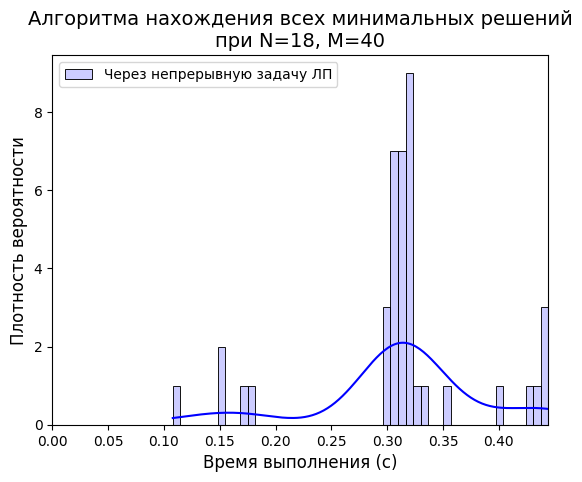

程序运行结束


In [ ]:
sns.histplot(calculation_time_1, bins=50, kde=True, color="blue", label="Через непрерывную задачу ЛП", alpha=0.2)

# 添加标题和标签
plt.xlim(0, max(calculation_time_1))
plt.title(f"Алгоритма нахождения всех минимальных решений\nпри N={N}, M={M}", fontsize=14)
plt.xlabel("Время выполнения (с)", fontsize=12)
plt.ylabel("Плотность вероятности", fontsize=12)
plt.legend()

# 显示图表
plt.show()

print('程序运行结束')
log_file.close()

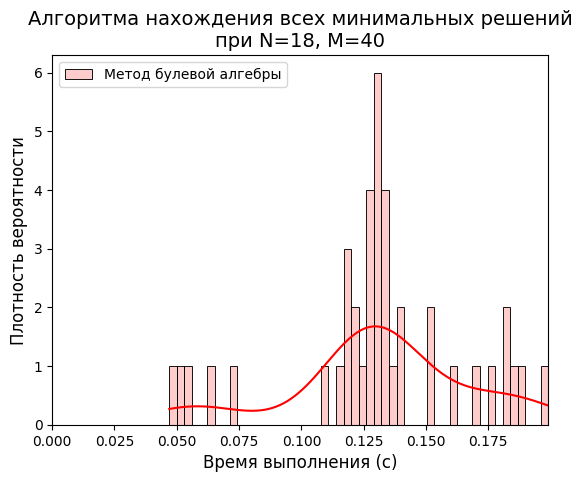

程序运行结束


In [ ]:
sns.histplot(calculation_time_2, bins=50, kde=True, color="red", label="Метод булевой алгебры", alpha=0.2)

# 添加标题和标签
plt.xlim(0, max(calculation_time_2))
plt.title(f"Алгоритма нахождения всех минимальных решений\nпри N={N}, M={M}", fontsize=14)
plt.xlabel("Время выполнения (с)", fontsize=12)
plt.ylabel("Плотность вероятности", fontsize=12)
plt.legend()

# 显示图表
plt.show()

print('程序运行结束')
log_file.close()

## 读取存档

In [ ]:
import pandas as pd
if False:
    filename = '68分钟-2/algo_typeL2025-B_N_18_M_1000_2025-05-07_18-47-03.csv'
    # filename = '18分钟/algo_typeLomonosov-B_N_20_M_500_2025-05-06_00-30-43.csv'
    # 读取 CSV 文件
    df = pd.read_csv(filename, encoding='ISO-8859-1')
    # 还原为原始的两个列表（如果是 numpy array，也可以用 .to_numpy()）
    calculation_time_1 = df["Algo_1"].tolist()
    calculation_time_2 = df["Algo_2"].tolist()
    calculation_time_3 = df["Algo_3"].tolist()
    calculation_time_4 = df["Algo_4"].tolist()
    N = int(df["N"].iloc[0])
    M = int(df["M"].iloc[0])